<a href="https://colab.research.google.com/github/PraneetVR/IIITDMJ-DL-Summer-School-Program-Assignments/blob/main/Week_2_Day_5_IIITDMJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 2 Day 5 Assignment

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

#Q1. Build a Basic Autoencoder
#Q2. Visualize Encoded Representations

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.43MB/s]


Training improved convolutional autoencoder...
Epoch 1/5, Loss: 0.0446
Epoch 2/5, Loss: 0.0108
Epoch 3/5, Loss: 0.0079
Epoch 4/5, Loss: 0.0068
Epoch 5/5, Loss: 0.0061
Generating visualizations...


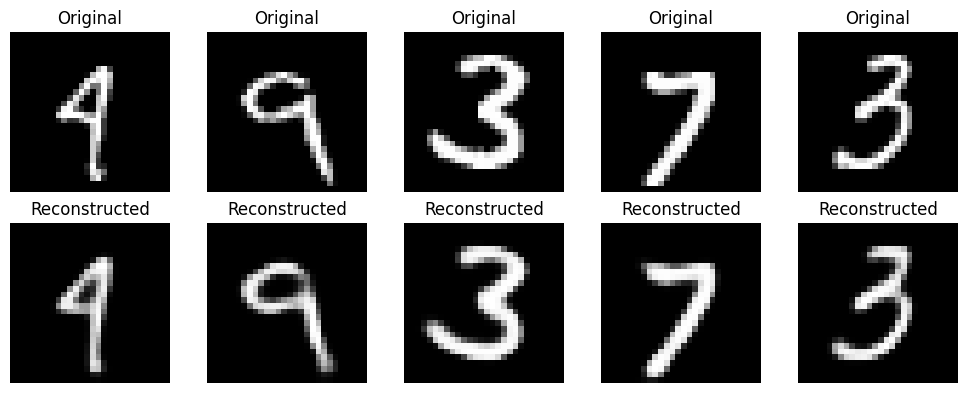

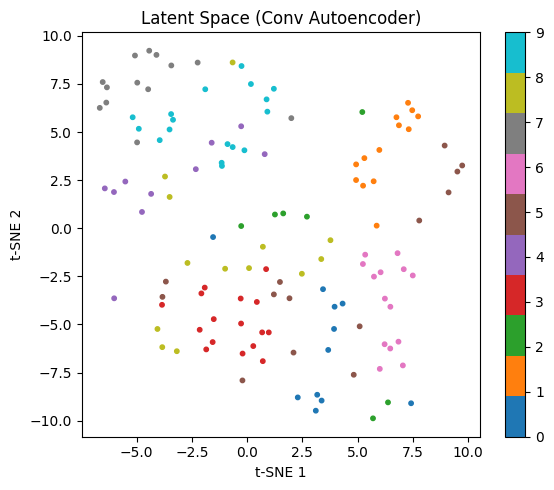

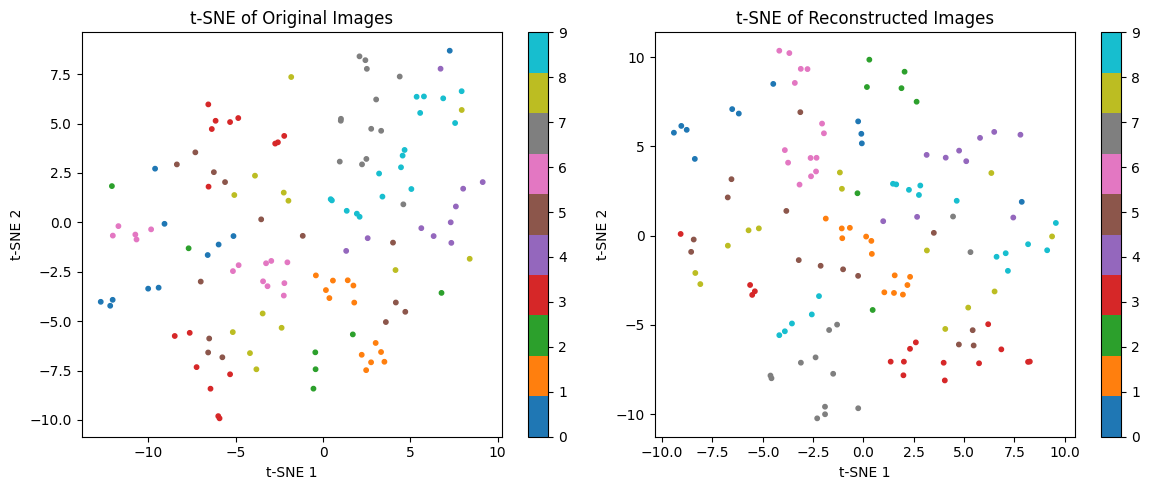

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
latent_dim = 64  # Latent space dimension
batch_size = 128
epochs = 5
learning_rate = 0.0005

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])  # Normalize to [0,1] for sigmoid output
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Define Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # [batch, 32, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [batch, 32, 14, 14]
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # [batch, 64, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [batch, 64, 7, 7]
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # [batch, 128, 7, 7]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, latent_dim),  # [batch, latent_dim]
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),  # [batch, 128, 7, 7]
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 64, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch, 32, 28, 28]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),  # [batch, 1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

# Training function
def train_autoencoder(model, train_loader, epochs):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        total_loss = 0
        for batch, _ in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output, _ = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')

# Visualization function
def visualize_results(model, data_loader, device):
    model.eval()
    images, labels = next(iter(data_loader))
    images = images.to(device)
    with torch.no_grad():
        reconstructed, z = model(images)
        z_np = z.cpu().numpy()
        reconstructed_np = reconstructed.cpu().numpy()
        original_np = images.cpu().numpy()

    # Plot original vs reconstructed images
    plt.figure(figsize=(10, 4))
    for i in range(5):
        # Original
        plt.subplot(2, 5, i+1)
        plt.imshow(original_np[i].reshape(28, 28), cmap='gray')
        plt.title('Original')
        plt.axis('off')
        # Reconstructed
        plt.subplot(2, 5, i+6)
        plt.imshow(reconstructed_np[i].reshape(28, 28), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # t-SNE visualization of latent space
    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(z_np)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels.numpy(), cmap='tab10', s=10)
    plt.colorbar(scatter)
    plt.title('Latent Space (Conv Autoencoder)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.show()

    # t-SNE visualization of original and reconstructed images
    # Flatten images for t-SNE
    original_flat = original_np.reshape(len(original_np), -1)  # [batch, 784]
    reconstructed_flat = reconstructed_np.reshape(len(reconstructed_np), -1)  # [batch, 784]

    # Compute t-SNE for original images
    tsne_original = TSNE(n_components=2, random_state=42)
    original_tsne = tsne_original.fit_transform(original_flat)

    # Compute t-SNE for reconstructed images
    tsne_reconstructed = TSNE(n_components=2, random_state=42)
    reconstructed_tsne = tsne_reconstructed.fit_transform(reconstructed_flat)

    # Plot t-SNE for original and reconstructed
    plt.figure(figsize=(12, 5))
    # Original t-SNE
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(original_tsne[:, 0], original_tsne[:, 1], c=labels.numpy(), cmap='tab10', s=10)
    plt.colorbar(scatter)
    plt.title('t-SNE of Original Images')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    # Reconstructed t-SNE
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(reconstructed_tsne[:, 0], reconstructed_tsne[:, 1], c=labels.numpy(), cmap='tab10', s=10)
    plt.colorbar(scatter)
    plt.title('t-SNE of Reconstructed Images')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == '__main__':
    # Initialize model
    model = ConvAutoencoder(latent_dim).to(device)

    # Train autoencoder
    print("Training improved convolutional autoencoder...")
    train_autoencoder(model, train_loader, epochs)

    # Visualize results
    print("Generating visualizations...")
    visualize_results(model, train_loader, device)

#Q3. Build a Denoising Autoencoder

Training denoising autoencoder...
Epoch 1/5, Loss: 0.0501
Epoch 2/5, Loss: 0.0161
Epoch 3/5, Loss: 0.0129
Epoch 4/5, Loss: 0.0117
Epoch 5/5, Loss: 0.0109
Generating denoising visualizations...


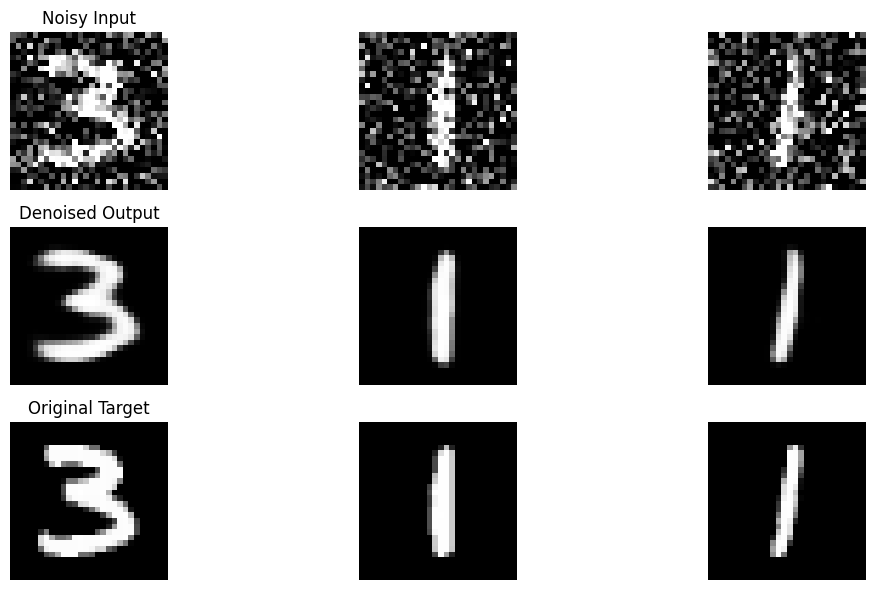

In [ ]:
# prompt: Q3. Build a Denoising Autoencoder (3 marks)
# Add random noise to the MNIST images.
# Train an autoencoder to take noisy images as input and clean images as output.
# Show 3 examples of (Noisy Input → Denoised Output → Original Target).

import matplotlib.pyplot as plt
# Function to add random noise to images
def add_noise(img, noise_factor=0.3):
    noise = torch.randn_like(img) * noise_factor
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)

# Denoising Autoencoder training function
def train_denoising_autoencoder(model, train_loader, epochs, noise_factor=0.3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        total_loss = 0
        for batch, _ in train_loader:
            batch = batch.to(device)
            noisy_batch = add_noise(batch, noise_factor).to(device) # Add noise
            optimizer.zero_grad()
            output, _ = model(noisy_batch) # Input is noisy
            loss = criterion(output, batch) # Target is clean
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')

# Visualization function for denoising autoencoder
def visualize_denoising_results(model, data_loader, device, num_examples=3, noise_factor=0.3):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images.to(device)
    noisy_images = add_noise(images, noise_factor).to(device)

    with torch.no_grad():
        denoised_images, _ = model(noisy_images)

    noisy_np = noisy_images.cpu().numpy()
    denoised_np = denoised_images.cpu().numpy()
    original_np = images.cpu().numpy()

    plt.figure(figsize=(12, 6))
    for i in range(num_examples):
        # Noisy Input
        plt.subplot(3, num_examples, i+1)
        plt.imshow(noisy_np[i].reshape(28, 28), cmap='gray')
        if i == 0: plt.title('Noisy Input')
        plt.axis('off')

        # Denoised Output
        plt.subplot(3, num_examples, i+num_examples+1)
        plt.imshow(denoised_np[i].reshape(28, 28), cmap='gray')
        if i == 0: plt.title('Denoised Output')
        plt.axis('off')

        # Original Target
        plt.subplot(3, num_examples, i+2*num_examples+1)
        plt.imshow(original_np[i].reshape(28, 28), cmap='gray')
        if i == 0: plt.title('Original Target')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # ... (previous code for ConvAutoencoder class definition and setup) ...

    # Initialize model
    model = ConvAutoencoder(latent_dim).to(device)

    # Train denoising autoencoder
    print("Training denoising autoencoder...")
    # Using the defined training function for denoising
    train_denoising_autoencoder(model, train_loader, epochs, noise_factor=0.4) # Increased noise factor

    # Visualize denoising results
    print("Generating denoising visualizations...")
    visualize_denoising_results(model, train_loader, device, num_examples=3, noise_factor=0.4) # Use the same noise factor for visualization